# Created by Wenhan Hua
Feb 10th. 2023

In [1]:
# Load the needed package
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import find_peaks

from scipy.integrate import solve_ivp

from tqdm import tqdm

Setting the motional constant of the e:
- $\omega_{rf} = \omega_{mm} = 10 GHz $
- $\omega_{radical} = 2 GHz $
- $\omega_{axial} = 300 MHz $
- $ d_{eff} = 200e-6 m $
- $ m = 9.10938297e-31 kg $
- $ q = 1.6e-19 $

In [42]:
# Load the parameters first 
# All in SI
wrf = 2 * np.pi* 10e9 # 10 GHz
wmm = 2 * np.pi* 10e9 # 10 GHz
wradical = 2 * np.pi * 2e9 # 2 GHz  
waxial = 2 * np.pi * 300e6 # 300 MHz
deff = 200e-6 # 200 micron
m = 9.10938297e-31 # 9.10938297e-31 kg 
q = 1.6e-19 # 1.6e-19 C

# Here are artical parameter
VoverU = 160 
r0 = 0.01 # 0.01 m

# Here are the tank circuit
Rp = 1e9
Q = 2000
wres = 786e7

# Define the spatial step size and the time step size

dt = 1e-12 # time step size: 0.01 mu s
T = 30e-8 # total time 30 mu s 
N = int(T/dt)

t_eval = np.linspace(0, T, N)

# Motion initialization

x0, y0, z0, vx0, vy0, vz0 = 0.1, 0.1, 0.1, 0., 0., 0.
Vec0 = x0, y0, z0, vx0, vy0, vz0

# Iteration Steps
iteration_steps = 3

progress_bar = tqdm(total=T, desc='Simulated time (s)', position=0, leave=True)

Simulated time (s):   0%|          | 0/3e-07 [00:00<?, ?it/s]

DC harmonic potential:

$$V_{dc} = \kappa U (\frac{2z^2 - x^2 - y^2}{2 r_0^2})$$

RF saddle harmonic potential:

$$ V_{rf} = V \cos(\Omega_{rf} t) \frac{x^2 - y^2}{2r_0^2} $$

Pesudo potential approximation (not used in dyamics simulation):

$$ U_{ps} = \frac{1}{4m\Omega_{rf}} (F_{rf})^2 = \frac{q^2 V^2}{2m\Omega_{rf}r_0^4}(x^2 + y^2) $$

radical secular frequency is:

$$\omega_{x,y} = \frac{qV}{\sqrt{2} m\Omega_{rf}r_0^2} $$

$$\omega_z = \sqrt{\frac{q\kappa U}{mr_0^2}} $$

by [littich-thesis.pdf-Page18](./littich-thesis.pdf) 

(??? Question: it is said $\omega_u = \sqrt{a_u + q_u^2/2} \omega_{rf} /2 = \sqrt{(\frac{4qU}{mr_0^2\Omega^2}) + 2(\frac{qV}{mr_0^2\Omega^2})^2 }\omega_{rf} /2 $ , so the last equation should only holds when $ a_u << (q_u)^2 $ )


If we connect the parameter like $U, V, \kappa, r_0 $ with the intial motional parameter $\omega_r, \omega_z$, the potential parameter we chosen will make more sense:

$$ V_{dc} = \frac{1}{2} m \omega_z^2 \frac{2z^2 - x^2 - y^2}{2} $$

$$ V_{rf} = \sqrt{2}m\omega_r \Omega_{rf}\cos(\Omega_{rf} t)\frac{x^2 - y^2}{2} $$

Both $ V_{dc} $ and $ V_{rf} $ have quaratic term , we can get the expression of $ E_{dc} $ and $ E_{rf} $:

$$ \vec{E}_{dc} =\frac{1}{2q} m \omega_z^2\quad( x, y, -2z)^T $$
$$ \vec{E}_{rf} = \frac{\sqrt{2}m\omega_r \Omega_{rf}}{ q}\cos(\Omega_{rf} t) \quad (-x, y, 0)^T $$


For simplification, I choose the "Vec" for donoting "x, y, z, vx, vz, vz"

In [3]:
def Vdc(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return 1/4/q * m * waxial ** 2* (2 * z ** 2 - x ** 2 - y ** 2)

def Vrf(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return m * wradical * wrf * np.sqrt(2) / q * np.cos(wrf * t) * (x ** 2- y ** 2) /2

def Edc(Vec, t):
    x, y, z, vx, vy, vz = Vec
    A = 1/2/q * m * waxial ** 2
    return A * x, A * y, -2 * A * z

def Erf(Vec, t):
    x, y, z, vx, vy, vz = Vec
    A = m * wradical * wrf * np.cos(wrf * t) * np.sqrt(2) / q
    return A * (- x), A * y, 0.
'''
# Calculate the Damping force generated by tank circuit
def DampingForce(Vec, t):
    tf = fftfreq(N, dt)[:N//2]
    Rez = Rp / (1 + Q ** 2 * (tf / wres - wres / tf) ** 2)
    

    return 0., 0., 0.
'''
#Calculate the JN noise of the circuit
def JNNoise(Vec, t):
    return 0., 0., 0.

# Calculate motional deviation according to Edc and Erf
def DevMotion_init(t, Vec):
    x, y, z, vx, vy, vz = Vec
    Ex, Ey, Ez = tuple(map(sum, zip(Edc(Vec, t),
                                    Erf(Vec, t))))
    ax = q * Ex / m
    ay = q * Ey / m
    az = q * Ez / m
    progress_bar.update(dt)
    return vx, vy, vz, ax, ay, az


Previously, I used Eular method for intergrating, but the total energy is not conserved, here I apply Runge-Kutta-Fehlberg Method, especially RK 45.

- RK45 intro: https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method

- Scipy for RK45: scipy.integrate.solve_ivp https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html


In [4]:
# Using RK45 to solve the ODE

solution = solve_ivp(fun=lambda t, Vec: DevMotion_init(t, Vec), 
                     t_span = (0, T), 
                     y0 = Vec0, 
                     t_eval = t_eval, 
                     first_step = 1e-13,
                     max_step = 1e-12,
                     method = 'RK45')
t_init = solution.t
VecResult_init = solution.y
x_init, y_init, z_init = VecResult_init[0, :], VecResult_init[1, :], VecResult_init[2, :]
vx_init, vy_init, vz_init = VecResult_init[3, :], VecResult_init[4, :], VecResult_init[5, :]
progress_bar.close()


'''
solution = odeint(DevMotion, Vec0, t_eval)
t = t_eval

x = solution[:, 0]
y = solution[:, 1]
z = solution[:, 2]
vx = solution[:, 3]
vy = solution[:, 4]
vz = solution[:, 5]
'''



Simulated time (s): 100%|█████████▉| 2.992729999987088e-07/3e-07 [00:15<00:00, 43427093.67s/it]  /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Simulated time (s): 600%|██████████| 1.8000070000307343e-06/3e-07 [01:49<-1:58:29, 60778606.54s/it] 


'\nsolution = odeint(DevMotion, Vec0, t_eval)\nt = t_eval\n\nx = solution[:, 0]\ny = solution[:, 1]\nz = solution[:, 2]\nvx = solution[:, 3]\nvy = solution[:, 4]\nvz = solution[:, 5]\n'

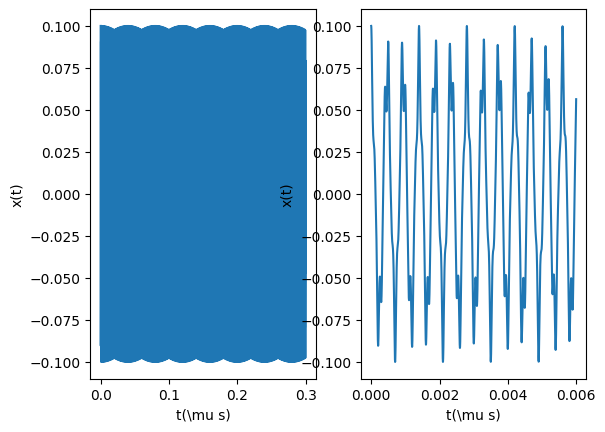

In [5]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,2)

# Plot the data on the axes
ax[0].plot(t_init*1e6, x_init)

# Add labels to the axes
ax[0].set_xlabel('t(\mu s)')
ax[0].set_ylabel('x(t)')

# Plot the data on the axes
Zoomnum = int(0.6e-8/dt)
ax[1].plot(t_init[:Zoomnum]*1e6, x_init[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t(\mu s)')
ax[1].set_ylabel('x(t)')

# Show the plot
plt.show()

Get the spectrum of the motion, using ```scipy.fft.fft ```and ```scipy.fft.fftfreq```

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html

using ```scipy.signal.find_peaks``` to find peaks and make captions

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

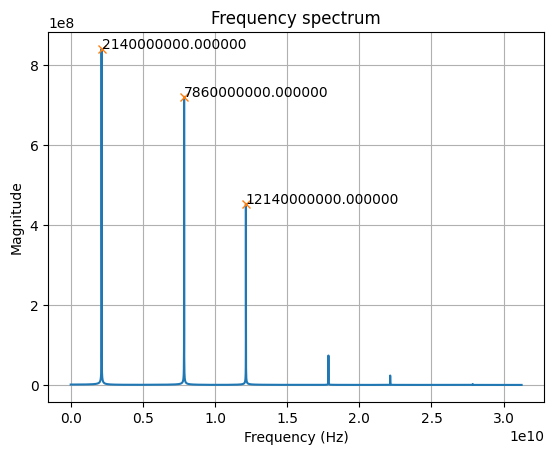

In [6]:
# Get the fourier spectrum of velocity

vxf_init = fft(vx_init)
vyf_init = fft(vy_init)
vzf_init = fft(vz_init)
tf = fftfreq(N, dt)

Front = 0
Cutoff = 16
vf = vxf_init[Front:Front + (vxf_init.size//Cutoff//2)]
ttf = tf[:N//2]
ttf = ttf[Front:Front + (ttf.size//Cutoff)]

# Get normalized magnitude of specturm
N_vf = 2.0/N * np.abs(vf[0:N//2])

if len(ttf) < len(N_vf):
    ttf = np.append(tf, [0])

# use find_peaks to get all the peaks
peaks, _ = find_peaks(N_vf, height=0)


# we only need the three largest peaks, therefore we find a border and find peaks again
temp = N_vf[peaks]
temp.sort()
temp = temp[::-1]
border = ( temp[2] + temp[3])/2

peaks, _ = find_peaks(N_vf, height= border)

#print("The location of the three largest peaks is {}, {}, {} Hz".format(tf[peaks[0]], tf[peaks[1]], tf[peaks[2]]))

# Plot the result
plt.plot(ttf, N_vf)
plt.plot(ttf[peaks], N_vf[peaks], "x")

for i in range(0,3):                                      
    plt.text(ttf[peaks[i]], N_vf[peaks[i]], "%f" % ttf[peaks[i]])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency spectrum')
plt.grid()
plt.show()

- induced current : $I = ev/d_{eff}$
- induced voltage : $U = IR = I Re(Z) = Re(Z) ev/d_{eff}$
- induced force : $F = -e U/d = - Re(Z) \frac{e^2}{d_{eff}^2} v$

$ Re(Z)$ can have time dependence, thus acting on the electron by different pattern. In a RLC parallel circuit, the impetence $ Z $ in the frequency domin is given by:

$$ Z_{LC} = (\frac{1}{R_p} + i\omega C + \frac{1}{i\omega L})^{-1} = \frac{R_p}{[1+iQ(\frac{\omega}{\omega_R} - \frac{\omega_R}{\omega} )]} $$

Real part and imaginary part:

$$ Re(Z_{LC}) = \frac{R_p}{1 + Q^2(\frac{w_R + dw}{w_R}- \frac{w_R}{w_R + dw})^2} $$

$$ Im(Z_{LC}) = - \frac{R_p Q(\frac{w_R + dw}{w_R}- \frac{w_R}{w_R + dw})^2}{1 + Q^2(\frac{w_R + dw}{w_R}- \frac{w_R}{w_R + dw})^2} $$

where $dw$ means the detuning from $w_R$, $dw = w - w_R$

In the time domin: 

$$F(t) = -e U/d = - Re[Z](t) \frac{e^2}{d_{eff}^2} v(t)$$

According to https://www.princeton.edu/~cuff/ele201/kulkarni_text/frequency.pdf,

$$ x(t)y(t) \leftrightarrow \frac{1}{2\pi}X(\omega) * Y(\omega) = \frac{1}{2\pi} \int_{-\infty}^{+\infty} X(\eta) Y(\omega - \eta) d\eta $$



In [37]:
# Calculate the Damping force generated by tank circuit

def DampingForce(Vec, t):
    posi = int(t/dt) - 1
    return Damping_Ex[posi], 0., 0.

'''
def DampingForce(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return - q / deff ** 2 * vx * Rp, - q / deff ** 2 * vx * Rp, - q / deff ** 2 * vx * Rp
'''
#Calculate the JN noise of the circuit
def JNNoise(Vec, t):
    return 0., 0., 0.

# Calculate motional deviation according to Edc and Erf
def DevMotion(t, Vec):
    x, y, z, vx, vy, vz = Vec
    Ex, Ey, Ez = tuple(map(sum, zip(Edc(Vec, t),
                                    Erf(Vec, t),
                                    DampingForce(Vec, t),
                                    JNNoise(Vec, t))))
    ax = q * Ex / m
    ay = q * Ey / m
    az = q * Ez / m
    progress_bar.update(dt)
    return vx, vy, vz, ax, ay, az


In [43]:
# Pre-prepare for calculating the damping force

Rezf = Rp / (1 + Q ** 2 * (tf / wres - wres / tf) ** 2)
'''
Rezf = []
for i in range(N):
    Rezf.append (Rp / complex(1, Q * (tf[i] / wres - wres / tf[i])))
'''
Damping_Exf = - q / deff ** 2 * np.convolve(vxf_init, Rezf)
# Damping_Exf = q / deff ** 2 * np.multiply(vxf_init, Rezf)
Damping_Ex_t = np.array(ifft(Damping_Exf))
Damping_Ex = list(Damping_Ex_t.real)
Damping_Ex =[ 1 * a for a in Damping_Ex]

progress_bar = tqdm(total=T, desc='Simulated time (s)', position=0, leave=True)
# Using RK45 to solve the ODE

solution = solve_ivp(fun=lambda t, Vec: DevMotion(t, Vec), 
                     t_span = (0, T), 
                     y0 = Vec0, 
                     t_eval = t_eval, 
                     first_step = 1e-13,
                     max_step = 1e-12,
                     method = 'RK45')

t_damp = solution.t
VecResult = solution.y
x_damp, y_damp, z_damp = VecResult[0, :], VecResult[1, :], VecResult[2, :]
vx_damp, vy_damp, vz_damp = VecResult[3, :], VecResult[4, :], VecResult[5, :]

progress_bar.close()

'''
solution = odeint(DevMotion, Vec0, t_eval)
t = t_eval

x = solution[:, 0]
y = solution[:, 1]
z = solution[:, 2]
vx = solution[:, 3]
vy = solution[:, 4]
vz = solution[:, 5]
'''



/var/folders/8w/vs_q5n850bs0hzh119krtydr0000gn/T/ipykernel_18552/1117706764.py:3: RuntimeWarning: divide by zero encountered in divide
  Rezf = Rp / (1 + Q ** 2 * (tf / wres - wres / tf) ** 2)
Simulated time (s):   0%|          | 0/3e-07 [02:17<?, ?it/s]
Simulated time (s): 600%|██████████| 1.8000190000307346e-06/3e-07 [02:01<-1:58:19, 67568230.15s/it] 


'\nsolution = odeint(DevMotion, Vec0, t_eval)\nt = t_eval\n\nx = solution[:, 0]\ny = solution[:, 1]\nz = solution[:, 2]\nvx = solution[:, 3]\nvy = solution[:, 4]\nvz = solution[:, 5]\n'

In [30]:
print(len(Damping_Exf))
print(len(vxf_init))

599999
300000


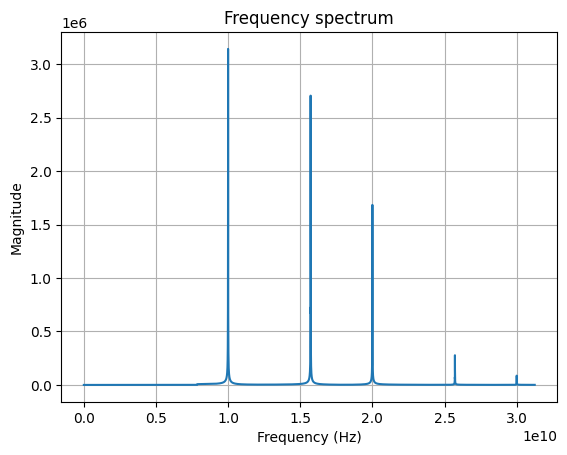

In [47]:
# Plot the E_sec t
N_Damping_Exf = 2.0/N * np.abs(Damping_Exf[0:N//2])
tf = fftfreq(N, dt)
ttf = tf[:N//2]


Front_Temp = 1
Cutoff_Temp = 16

ttf = ttf[Front_Temp:Front_Temp + (ttf.size//Cutoff_Temp)]
N_Damping_Exf = N_Damping_Exf[Front_Temp : Front_Temp +len(N_Damping_Exf)//Cutoff_Temp]
plt.plot(ttf, N_Damping_Exf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency spectrum')
plt.grid()
plt.show()

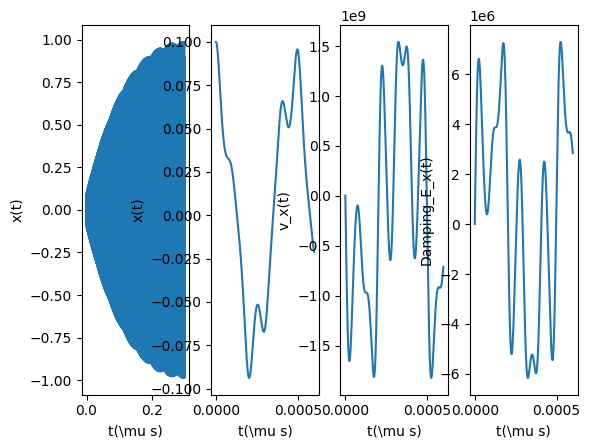

600


In [45]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,4)

# Plot the data on the axes
ax[0].plot(t_damp*1e6, x_damp)

# Add labels to the axes
ax[0].set_xlabel('t(\mu s)')
ax[0].set_ylabel('x(t)')

Zoomnum = int(0.6e-9/dt)
# Plot the data on the axes
ax[1].plot(t_damp[:Zoomnum]*1e6, x_damp[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t(\mu s)')
ax[1].set_ylabel('x(t)')

# Plot the velocity 
ax[2].plot(t_damp[:Zoomnum] * 1e6, vx_damp[: Zoomnum])

# Add labels to the axes
ax[2].set_xlabel('t(\mu s)')
ax[2].set_ylabel('v_x(t)')

# Plot the damping force
Damping_Ex = - q / deff ** 2 * vx_damp * Rp
ax[3].plot(t_damp[:Zoomnum] * 1e6, Damping_Ex[: Zoomnum])

# Add labels to the axes
ax[3].set_xlabel('t(\mu s)')
ax[3].set_ylabel('Damping_E_x(t)')
# Show the plot
plt.show()
print(Zoomnum)

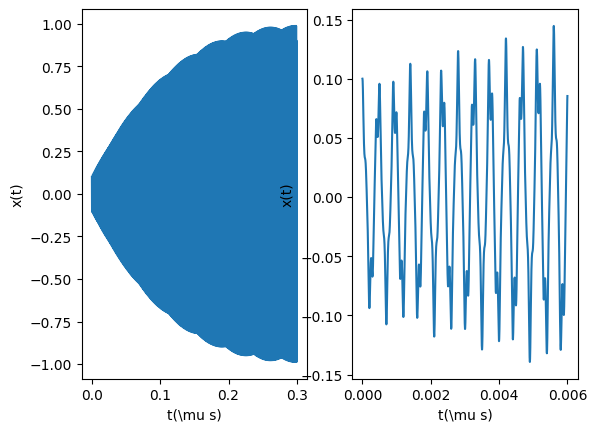

In [46]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,2)

# Plot the data on the axes
ax[0].plot(t_damp*1e6, x_damp)

# Add labels to the axes
ax[0].set_xlabel('t(\mu s)')
ax[0].set_ylabel('x(t)')

# Plot the data on the axes
Zoomnum = int(0.6e-8/dt)
ax[1].plot(t_damp[:Zoomnum]*1e6, x_damp[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t(\mu s)')
ax[1].set_ylabel('x(t)')

# Show the plot
plt.show()


1.4233410890625002e-08

Calculate the kinetic energy of the particle, method is mainly based on
[rf-induced heating dynamics of noncrystallized trapped ions](./vHGWBSM.pdf)

The Method is following the Section. III. Full Ion Dynamics Simulation

Code is here(By Matlab): https://zenodo.org/record/5884496#.Y-6NGuyZP2d

The total energy $E_{tot}$ is given by:

$$ E_{tot} = \sum_i [V_{DC}(\vec{r_i}) + V_{rf})\vec{r_i},t + V_{kin}(v_i) + \frac{1}{2}\sum_{j\not = i} V_{Coul} (\vec{r_i},\vec{r_j})], $$

and Note the energies corresponding to two timescales:

$$ E_{tot} = E_{rf} + E_{sec} $$

for ions, we calculate the total energy by:

- $V_{kin} = (1/2) m_i v_i^2 $
- $V_{Coul} = \frac{1}{4\pi \epsilon_0} \frac{q_i q_j}{|r_i - r_j|}$

To get the secluar energy, we do the follows:

- replace $V_{rf}$ with pseudopotential(effective static potential)
$$ V_{ps} = \frac{q^2}{4m_i \Omega_{rf}^2} |\nabla V_{rf}(r_i)|^2 $$

- replace $ r_i $ and $v_i$ with secular components, $ r_i^{sec}$ and $v_i^{sec} $

If $\omega_{secular} = \omega_{radical} << \Omega_{rf}$, then

(???)
$$ \frac{d^2 r_i^{(rf)}}{dt^2} \approx - \frac{q \nabla V_{rf}(r_{sec})}{m} \cos(\Omega_{rf}t). $$

If $r_i^{rf}$ is small enough that $\nabla V_{rf}(r_i^{sec})$ is approximately constant, $\nabla V_{rf}(r_i^{sec})$ is approximataly constant, $r^{sec} \approx r^0$, then:

$$ r^{rf} \approx - \frac{q\nabla V_{rf}(r^0)}{m \Omega_{rf}^2}\cos(\Omega_{rf}t). $$

The secular motion is iteratively approximated by

$$ r_i^1 = r_i^0 - r_i^{rf} = r_i^0 + \frac{q \nabla V_{rf}(r_i^0)}{m\Omega_{rf}^2}\cos(\Omega_{rf}t).$$

then:

$$ r_i^{n+1} = r_i + \frac{q\nabla V_{rf}(r_i^n)}{m\Omega_{rf}^2}\cos(\Omega_{rf}t).$$


I will use this interative equation to get $r^n \approx r^{sec}$, then using $ v = dr/dt $ to get velocityies and pesudopotential approximation $V_{ps}$

Then the secular energy:

$$ E_{sec} = V_{dc}(r^n) + V_{ps}(r^n) + V_{kin}(v^n) + \frac{1}{2} \sum_{j\not = i} V_{Coul}(r^n, r^n) $$

In [152]:
# Define the pesudo-potential

def Vps(Vec, t):
    x, y, z, vx, vy, vz = Vec
    Ex, Ey, Ez = Erf(Vec, t)
    return q ** 2 / 4 / m / wrf ** 2 * (Ex ** 2 + Ey ** 2 + Ez ** 2)

# Initialization for secular position

x_final = x_damp
y_final = y_damp
z_final = z_damp

x_sec = x_final.copy()
y_sec = y_final.copy()
z_sec = z_final.copy()

vx_sec = [vx0] + np.gradient(x_final) / dt
vy_sec = [vy0] + np.gradient(y_final) / dt 
vz_sec = [vz0] + np.gradient(z_final) / dt

# Do the iteration
for step in range(iteration_steps):
    for i in range(len(t_eval)):
        Vec = x_sec[i], y_sec[i], z_sec[i], vx_sec[i], vy_sec[i], vz_sec[i]
        Ex, Ey, Ez = Erf(Vec, t_eval[i])
        x_sec = x_final + q * Ex / m / wrf ** 2 * np.cos(wrf * t_eval[i])
        y_sec = y_final + q * Ex / m / wrf ** 2 * np.cos(wrf * t_eval[i])
        z_sec = z_final + q * Ex / m / wrf ** 2 * np.cos(wrf * t_eval[i])

vx_sec = [vx0] + np.gradient(x_sec) / dt
vy_sec = [vy0] + np.gradient(y_sec) / dt
vz_sec = [vz0] + np.gradient(z_sec) / dt

E_sec = np.zeros(len(t_eval))

for i in range(len(t_eval)):
    Vec = x_sec[i], y_sec[i], z_sec[i], vx_sec[i], vy_sec[i], vz_sec[i]
    t = t_eval[i]
    E_sec[i] = Vdc(Vec, t) + Vps(Vec, t) \
        + 0.5 * m * (vx_sec[i] ** 2 + vy_sec[i] ** 2 + vz_sec[i] ** 2)
        


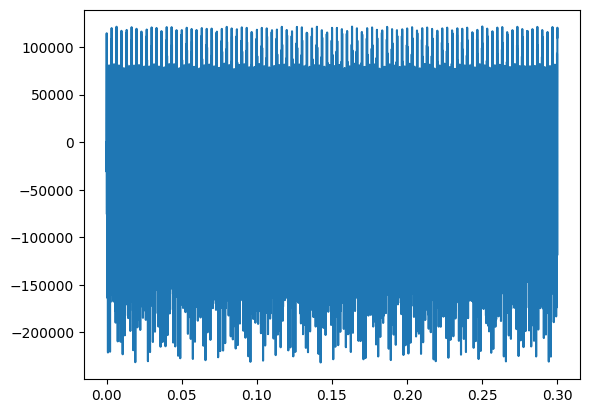

In [ ]:
# Plot the E_sec t

plt.plot(t_eval*1e6, E_sec)